# 3D VISION AND EXTENDED REALITY

**Project: **

- Qiqi Zhang
- Francisco Pasian

In [1]:
# IMPORT PACKAGES

import numpy as np
import sys
import PIL
import cv2
import os
import zipfile
import glob
from PIL import Image
import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import os

In [3]:
os.getcwd()

'c:\\Users\\fap_9\\Documents\\Unipd\\3DVisionandExtendedReality\\Labs\\final_project'

In [10]:
# Install necessary packages
#!pip -qq install cmake libopencv-dev

# Clone OpenCV repository
!git clone https://github.com/opencv/opencv.git
!git clone https://github.com/opencv/opencv_contrib.git

# Create build directory
!mkdir C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\opencv-python\build
%cd C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\opencv-python\build

# Configure OpenCV with CMake
#!cmake -DOPENCV_ENABLE_NONFREE=ON -DOPENCV_EXTRA_MODULES_PATH=C:\Users\fap_9\anaconda3\unipd\Lib\site-packages\opencv-python\opencv_contrib\modules  C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\opencv-python\opencv

# cmake -D CMAKE_BUILD_TYPE=RELEASE -D OPENCV_ENABLE_NONFREE=ON -DBUILD_opencv_legacy=OFF  -DCMAKE_C_COMPILER=C:\MinGW\bin\gcc.exe -DCMAKE_CXX_COMPILER=C:\MinGW\bin\g++.exe -D OPENCV_EXTRA_MODULES_PATH=C:\Users\fap_9\anaconda3\unipd\Lib\site-packages\opencv-python\opencv_contrib\modules ..

!cmake -D CMAKE_BUILD_TYPE=RELEASE -D OPENCV_ENABLE_NONFREE=ON -DBUILD_opencv_legacy=OFF -G "Visual Studio 17 2022" -D OPENCV_EXTRA_MODULES_PATH=C:\Users\fap_9\anaconda3\unipd\Lib\site-packages\opencv-python\opencv_contrib\modules C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\opencv-python\opencv

# Build and install OpenCV
!make -j8
!make install

%cd C:\Users\fap_9\Documents\Unipd\3DVisionandExtendedReality\Labs\final_project

fatal: destination path 'opencv' already exists and is not an empty directory.
fatal: destination path 'opencv_contrib' already exists and is not an empty directory.


C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\opencv-python\build


A subdirectory or file C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\opencv-python\build already exists.
CMake Error: Error: generator : Visual Studio 17 2022
Does not match the generator used previously: NMake Makefiles
Either remove the CMakeCache.txt file and CMakeFiles directory or choose a different binary directory.
make: *** No targets specified and no makefile found.  Stop.


C:\Users\fap_9\Documents\Unipd\3DVisionandExtendedReality\Labs\final_project


make: *** No rule to make target `install'.  Stop.


TODO

- Pre-process images (gauss smoothing, filters, etc)
- Local SURF (Speeded-Up Robust Features) descriptors
- Autoencoder
- Use/compare data aumented images
- Install and apply COLMAP
- Compare 3D reconstruction with autoencoders and without autoencoders
- Performance evaluation


## 1. Import data

In [4]:
# data direction
cwd = os.getcwd()
file_name = 'SfM_quality_evaluation-master.zip'

In [5]:
def read_zip(all_folders, n, sort=False, extension='.jpg'):
    """
    Reads from Zip files
    folder :: path of the zipped folder
    n :: amount of images to be extracted
    sort :: sort the list of images - (useful when plot orginal-mask together)
    extension :: extension of the image - if necessary
    """
    
    try:
        original_img = []
        mask_img = []
        list_archive = []
        i=0
        for folder in all_folders:
            with zipfile.ZipFile(folder, mode='r') as archive:
                #archive.printdir()
                # list original image files and its mask
                original_img.extend([archive.extract(file) for file in archive.namelist() if file.find('org') != -1])
                mask_img.extend([archive.extract(file) for file in archive.namelist() if file.find('label') != -1])

        # sort all images
        if sort:
            original_img = sorted(original_img)
            mask_img = sorted(mask_img)
        
    except zipfile.BadZipFile as error:
        print(error)

    return original_img[:n], mask_img[:n] # n_original_imag,n_mask_imag

In [6]:
# unpack image data
with zipfile.ZipFile(file_name) as file:
    print('UnZip file')

    # ZipFile.infolist() returns a list containing all the members of an archive file
    #print(file.infolist())

    # ZipFile.namelist() returns a list containing all the members with names of an archive file
    #print(file.namelist())

    print('\n')
    print(file.namelist()[0])
    print(file.namelist()[1])

    # castle-P30
    sample_img = [x for x in file.namelist() if x.find('castle-P30') != -1]
    original_img = [file.extract(x) for x in sample_img if (x.find('jpg') != -1 and x.find('camera') == -1)]
    camera = [x for x in sample_img if (x.find('jpg') != -1 and x.find('camera') != -1)]
    print('\n')

    # Herz-Jesus-P25
    sample_img = [x for x in file.namelist() if x.find('Herz-Jesus-P25') != -1]
    original_img = [file.extract(x) for x in sample_img if (x.find('jpg') != -1 and x.find('camera') == -1)]
    camera = [x for x in sample_img if (x.find('jpg') != -1 and x.find('camera') != -1)]
    print('\n')

    # ZipFile.getinfo(path = filepath) returns the information about a member of Zip file.
    # It raises a KeyError if it doesn't contain the mentioned file
    print(file.getinfo(file.namelist()[-1]))

UnZip file


SfM_quality_evaluation-master/
SfM_quality_evaluation-master/Benchmarking_Camera_Calibration_2008/




<ZipInfo filename='SfM_quality_evaluation-master/Readme.txt' compress_type=deflate file_size=1146 compress_size=590>


In [7]:
camera

['SfM_quality_evaluation-master/Benchmarking_Camera_Calibration_2008/Herz-Jesus-P25/gt_dense_cameras/0000.jpg.camera',
 'SfM_quality_evaluation-master/Benchmarking_Camera_Calibration_2008/Herz-Jesus-P25/gt_dense_cameras/0001.jpg.camera',
 'SfM_quality_evaluation-master/Benchmarking_Camera_Calibration_2008/Herz-Jesus-P25/gt_dense_cameras/0002.jpg.camera',
 'SfM_quality_evaluation-master/Benchmarking_Camera_Calibration_2008/Herz-Jesus-P25/gt_dense_cameras/0003.jpg.camera',
 'SfM_quality_evaluation-master/Benchmarking_Camera_Calibration_2008/Herz-Jesus-P25/gt_dense_cameras/0004.jpg.camera',
 'SfM_quality_evaluation-master/Benchmarking_Camera_Calibration_2008/Herz-Jesus-P25/gt_dense_cameras/0005.jpg.camera',
 'SfM_quality_evaluation-master/Benchmarking_Camera_Calibration_2008/Herz-Jesus-P25/gt_dense_cameras/0006.jpg.camera',
 'SfM_quality_evaluation-master/Benchmarking_Camera_Calibration_2008/Herz-Jesus-P25/gt_dense_cameras/0007.jpg.camera',
 'SfM_quality_evaluation-master/Benchmarking_Cam

In [8]:
original_img

['c:\\Users\\fap_9\\Documents\\Unipd\\3DVisionandExtendedReality\\Labs\\final_project\\SfM_quality_evaluation-master\\Benchmarking_Camera_Calibration_2008\\Herz-Jesus-P25\\images\\0000.jpg',
 'c:\\Users\\fap_9\\Documents\\Unipd\\3DVisionandExtendedReality\\Labs\\final_project\\SfM_quality_evaluation-master\\Benchmarking_Camera_Calibration_2008\\Herz-Jesus-P25\\images\\0001.jpg',
 'c:\\Users\\fap_9\\Documents\\Unipd\\3DVisionandExtendedReality\\Labs\\final_project\\SfM_quality_evaluation-master\\Benchmarking_Camera_Calibration_2008\\Herz-Jesus-P25\\images\\0002.jpg',
 'c:\\Users\\fap_9\\Documents\\Unipd\\3DVisionandExtendedReality\\Labs\\final_project\\SfM_quality_evaluation-master\\Benchmarking_Camera_Calibration_2008\\Herz-Jesus-P25\\images\\0003.jpg',
 'c:\\Users\\fap_9\\Documents\\Unipd\\3DVisionandExtendedReality\\Labs\\final_project\\SfM_quality_evaluation-master\\Benchmarking_Camera_Calibration_2008\\Herz-Jesus-P25\\images\\0004.jpg',
 'c:\\Users\\fap_9\\Documents\\Unipd\\3DVisio

(-0.5, 3071.5, 2047.5, -0.5)

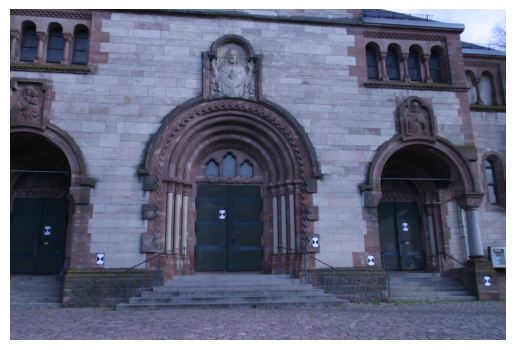

In [9]:
#fig, ax = plt.subplots(1,1, figsize=(20,8)) #int(n/columns)
#ax = ax.ravel()
#fig.tight_layout()

im_org = cv2.imread(original_img[7])
im_org = cv2.cvtColor(im_org, cv2.COLOR_BGR2RGB) 

plt.imshow(im_org)
plt.axis('off')


In [10]:
training_image = im_org

In [11]:
# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

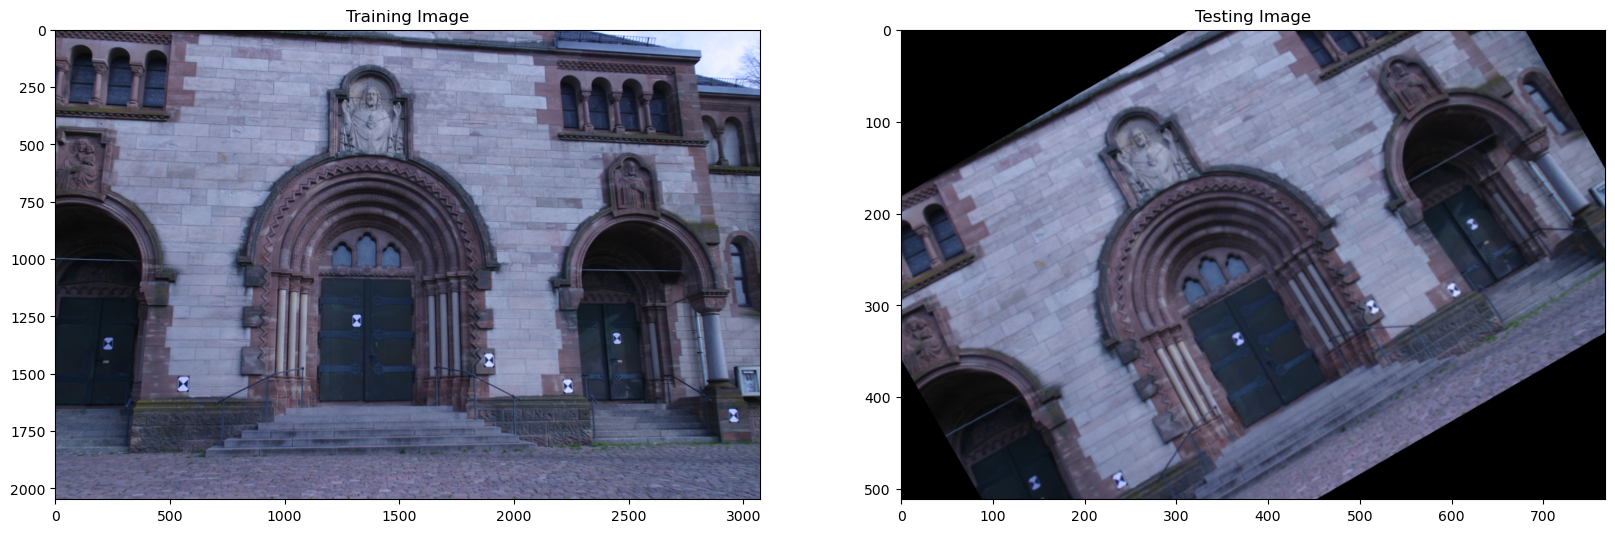

In [12]:
# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

In [2]:
cv2.__version__

'4.6.0'

In [11]:
!pip uninstall opencv-python opencv-contrib-python -y

In [12]:
!pip install opencv-contrib-python

   ---------------------------------------- 0.0/45.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/45.5 MB 4.3 MB/s eta 0:00:11
    --------------------------------------- 0.6/45.5 MB 7.7 MB/s eta 0:00:06
   - -------------------------------------- 2.1/45.5 MB 16.5 MB/s eta 0:00:03
   --- ------------------------------------ 4.2/45.5 MB 24.3 MB/s eta 0:00:02
   ----- ---------------------------------- 6.6/45.5 MB 30.1 MB/s eta 0:00:02
   ------- -------------------------------- 8.4/45.5 MB 31.8 MB/s eta 0:00:02
   --------- ------------------------------ 11.1/45.5 MB 46.7 MB/s eta 0:00:01
   ----------- ---------------------------- 13.4/45.5 MB 50.4 MB/s eta 0:00:01
   -------------- ------------------------- 16.0/45.5 MB 59.5 MB/s eta 0:00:01
   ---------------- ----------------------- 19.0/45.5 MB 54.4 MB/s eta 0:00:01
   ------------------- -------------------- 22.0/45.5 MB 59.5 MB/s eta 0:00:01
   --------------------- ------------------ 24.9/45.5 MB 59.8 MB/s et

In [2]:
!pip uninstall opencv-python opencv-python-headless opencv-contrib-python

In [11]:
%cd C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\cmake\data\bin
print(os.getcwd())
!CMAKE_ARGS="-DOPENCV_ENABLE_NONFREE=ON" pip install -v --no-binary=opencv-contrib-python opencv-contrib-python==4.10.0.84

C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\cmake\data\bin
C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\cmake\data\bin


Environment variable C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\cmake\data\bin not defined
'CMAKE_ARGS' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!pip uninstall opencv-contrib-python -y

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Successfully uninstalled opencv-contrib-python-4.10.0.84


In [3]:
#cv2.xfeature2d.SURF_create()

AttributeError: module 'cv2' has no attribute 'xfeature2d'

In [1]:
!pip uninstall opencv-contrib-python -y
#3.4.0.14

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Successfully uninstalled opencv-contrib-python-4.10.0.84


In [4]:
import cv2

cv2.__version__

'4.10.0'

In [1]:
a = !pip list


In [3]:
[i for i in a if i.find('open')!=-1]

['openpyxl                      3.0.10', 'smart-open                    5.2.1']

In [6]:

cv2.xfeatures2d_SURF.create()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1028: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


In [ ]:
!cmake -D OPENCV_ENABLE_NONFREE=ON C:\Users\fap_9\anaconda3\envs\unipd\Lib\site-packages\

In [3]:
cv2.xfeatures2d.SURF_create()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1028: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


In [122]:
####
## Detect keypoints and Create Descriptor
####
#a = cv2.xfeatures2d.SURF.getDefaultName()	
#surf = cv2.xfeatures2d.SURF.create(800)
surf = cv2.SIFT_create(800)


train_keypoints, train_descriptor = surf.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = surf.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (15, 255, 10))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(30,20))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size)#, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size)#, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

TypeError: unbound method Feature2D.getDefaultName() needs an argument

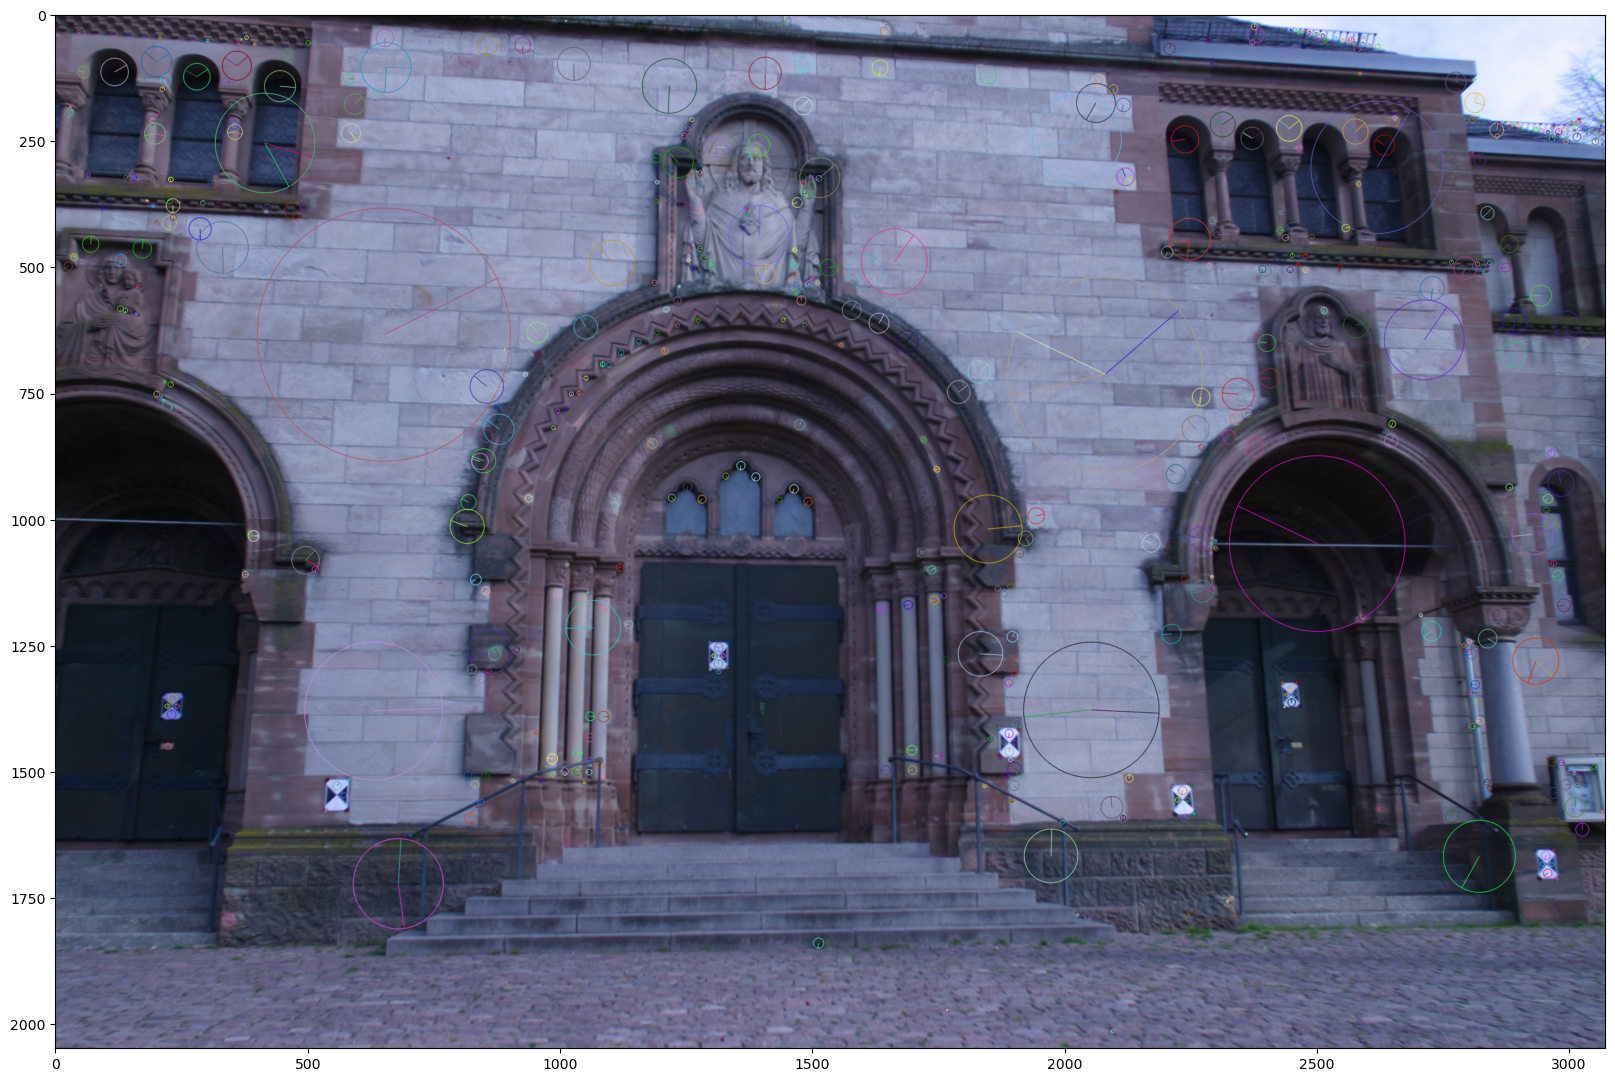

In [112]:
plt.figure(figsize=(20,20))
plt.imshow(keypoints_with_size)

In [61]:
query_image = training_gray

db_image = test_gray

In [63]:
sift = cv2.SIFT_create()

# Detects keypoints and computes the descriptors
# keypoints, descriptors	=	cv2.Feature2D.detectAndCompute(	image, mask[, descriptors[, useProvidedKeypoints]]	) 
keypoints_q, descriptors_q = sift.detectAndCompute(query_image, None)
# Print number of keypoints
print(f"Number of detected keypoints/descriptors (Query image): {len(keypoints_q)}")
keypoints_db, descriptors_db = sift.detectAndCompute(db_image, None)
# Print number of keypoints
print(f"Number of detected keypoints/descriptors (Database image): {len(keypoints_db)}")


Number of detected keypoints/descriptors (Query image): 7502
Number of detected keypoints/descriptors (Database image): 1781


In [64]:
# Select 1st keypoint and show (some of) its attributes
kpt = keypoints_q[0]
des = descriptors_q[0]

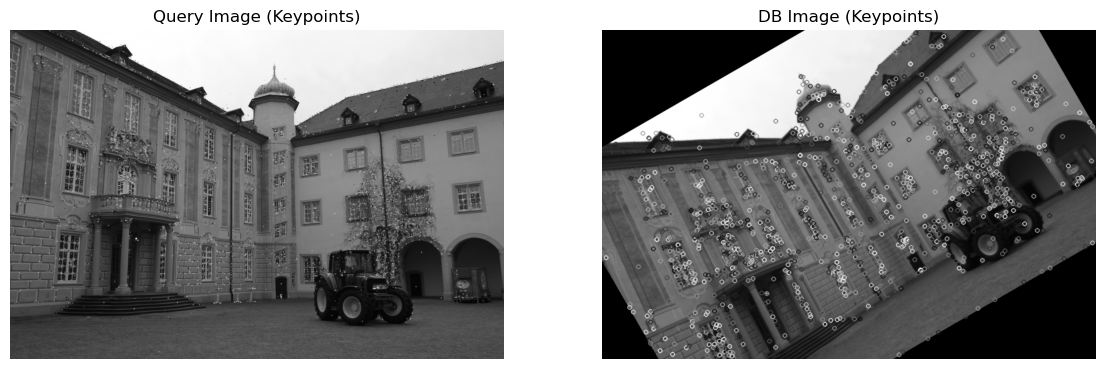

In [67]:
# Copy images
q_img = query_image.copy()
db_img = db_image.copy()

# Draw keypoints of the original image
# outImage	=	cv2.drawKeypoints(	image, keypoints, outImage[, color[, flags]]	)
cv2.drawKeypoints(q_img, keypoints_q, q_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)
                                        #cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS   
cv2.drawKeypoints(db_img, keypoints_db, db_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)   

q_img = cv2.cvtColor(q_img, cv2.COLOR_GRAY2RGB)
db_img = cv2.cvtColor(db_img, cv2.COLOR_GRAY2RGB)

# Display image with keypoints                        
plt.figure(figsize=(14, 8)), 
plt.subplot(1,2,1), plt.imshow(q_img), plt.title("Query Image (Keypoints)"), plt.axis("off")
plt.subplot(1,2,2), plt.imshow(db_img), plt.title("DB Image (Keypoints)"),  plt.axis("off")
plt.show()

## 2. Preprocess Data